# Enterprise-Ready Research Pipeline for Chess Gender Inequality

This notebook implements an enterprise-grade research pipeline with advanced features:

## Business Value Features

1. **Advanced Analytics**
   - Sentiment analysis of paper abstracts
   - Key term extraction and topic analysis
   - Custom relevance scoring algorithm

2. **Enterprise Storage**
   - SQLite database integration
   - Structured data model with proper relationships
   - Run history tracking with unique identifiers

3. **Performance Optimization**
   - Smart caching system for repeated searches
   - Efficient data processing with pandas

4. **Quality Assurance**
   - Automated testing of core pipeline functions
   - Comprehensive error handling
   - Detailed logging for audit purposes

5. **Enhanced Visualization**
   - Interactive dashboards with Plotly
   - Multiple visualization formats (PNG, SVG, HTML)
   - Cross-filtering capabilities

6. **Enterprise Deployment**
   - Docker containerization
   - Docker Compose for service orchestration
   - Volume mounting for persistent storage

## Usage in Business Context

This pipeline can be used by:
- Research departments tracking gender equality initiatives
- HR teams developing diversity programs
- Academic institutions studying gender representation
- Sports organizations analyzing participation demographics

---

# Docker Setup for Chess Gender Inequality Research

This project includes Docker configurations to ensure all dependencies are consistently available:

## Option 1: Using Docker Compose (Recommended)

1. Build and start all services:
   ```bash
   docker-compose up -d
   ```

2. Access the notebook and API:
   - Jupyter Notebook: http://localhost:8888
   - API Server: http://localhost:5000

3. Stop all services:
   ```bash
   docker-compose down
   ```

## Option 2: Using Docker directly

1. Build the Docker image:
   ```bash
   docker build -t chess-gender-inequality .
   ```

2. Run the container with this notebook:
   ```bash
   docker run -p 8888:8888 -p 5000:5000 -v ${PWD}:/app -v ${PWD}/exports:/app/exports -v ${PWD}/logs:/app/logs --user root chess-gender-inequality
   ```

   For Windows PowerShell specifically:
   ```powershell
   docker run -p 8888:8888 -p 5000:5000 -v ${PWD}:/app -v ${PWD}/exports:/app/exports -v ${PWD}/logs:/app/logs --user root chess-gender-inequality
   ```

No token or password is required for Jupyter access. All necessary packages are pre-installed in the Docker image.

# Academic Paper Search Pipeline for Chess Gender Inequality

This notebook implements a pipeline to automatically search Google Scholar for academic papers related to gender inequality in chess, focusing on the underrepresentation of women grandmasters. The pipeline will:

1. Import required libraries
2. Set up a Google Scholar scraper
3. Define a search query for chess gender inequality
4. Fetch academic papers from Google Scholar
5. Parse and store paper metadata
6. Filter and analyze papers by gender inequality topics
7. Visualize search results

---

# Running This Notebook in VS Code with Docker

You can run this notebook in two ways:

## Method 1: Direct Browser Access
1. Start the Docker container
2. Open `http://localhost:8888` in your browser
3. Open this notebook and run it

## Method 2: VS Code Integration
1. Start the Docker container as usual
2. In VS Code, follow these steps:
   - Click on the kernel selector in the top right corner
   - Select "Select Another Kernel..."
   - Choose "Existing Jupyter Server..."
   - Enter `http://localhost:8888` as the server URL (no token needed)
   - Select the kernel from the Docker environment

This allows you to run the notebook directly in VS Code while using the Docker environment.

In [1]:
# Import Required Libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Set display options for pandas
pd.set_option('display.max_colwidth', None)

In [2]:
# Set up export utilities and logging
import os
import datetime
import logging
from pathlib import Path

# Create export directories if they don't exist
export_dir = Path("exports")
export_dir.mkdir(exist_ok=True)

logs_dir = Path("logs")
logs_dir.mkdir(exist_ok=True)

db_dir = Path("database")
db_dir.mkdir(exist_ok=True)

# Get current timestamp for filenames
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Set up logging
logging.basicConfig(
    filename=f"logs/run_{timestamp}.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)

# Log the start of the run
logging.info(f"Starting new research run with timestamp: {timestamp}")

# Function to create export paths with timestamps
def get_export_path(base_name, extension="csv"):
    """Generate a timestamped export path"""
    return export_dir / f"{base_name}_{timestamp}.{extension}"

# Database utilities for enterprise storage
try:
    import sqlite3
    import pandas as pd
    
    def init_database():
        """Initialize SQLite database with required tables"""
        conn = sqlite3.connect(db_dir / 'research_data.db')
        cursor = conn.cursor()
        
        # Create tables if they don't exist
        cursor.execute('''
        CREATE TABLE IF NOT EXISTS runs (
            run_id TEXT PRIMARY KEY,
            timestamp TEXT,
            query TEXT,
            num_results INTEGER
        )
        ''')
        
        cursor.execute('''
        CREATE TABLE IF NOT EXISTS papers (
            paper_id INTEGER PRIMARY KEY AUTOINCREMENT,
            run_id TEXT,
            title TEXT,
            authors_year TEXT,
            link TEXT,
            snippet TEXT,
            relevance_score REAL,
            sentiment REAL,
            key_terms TEXT,
            FOREIGN KEY (run_id) REFERENCES runs (run_id)
        )
        ''')
        
        conn.commit()
        conn.close()
        logging.info("Database initialized successfully")
        return True
    
    def save_to_database(run_id, query, all_papers_df, top_papers_df=None):
        """Save research results to SQLite database"""
        conn = sqlite3.connect(db_dir / 'research_data.db')
        
        # Record the run
        run_data = pd.DataFrame({
            'run_id': [run_id],
            'timestamp': [datetime.datetime.now().isoformat()],
            'query': [query],
            'num_results': [len(all_papers_df)]
        })
        run_data.to_sql('runs', conn, if_exists='append', index=False)
        
        # Save all papers with run_id reference
        all_papers_df['run_id'] = run_id
        all_papers_df.to_sql('papers', conn, if_exists='append', index=False)
        
        conn.close()
        logging.info(f"Saved run {run_id} with {len(all_papers_df)} papers to database")
        return True
    
    # Initialize the database
    db_initialized = init_database()
    print("Enterprise database storage initialized.")
    
except ImportError as e:
    logging.warning(f"Database setup skipped: {str(e)}")
    print(f"Database setup skipped: {str(e)}")
    db_initialized = False

# Create a README for this export
with open(export_dir / f"README_{timestamp}.md", "w") as f:
    f.write(f"# Chess Gender Inequality Research - {timestamp}\n\n")
    f.write("This directory contains the results of an automated search for academic papers on gender inequality in chess.\n\n")
    f.write("## Files\n\n")
    f.write(f"- `all_papers_{timestamp}.csv`: All papers found in the search\n")
    f.write(f"- `top_papers_{timestamp}.csv`: Top 5 most relevant papers based on keyword analysis\n")
    f.write(f"- `top_papers_graph_{timestamp}.png`: Visualization of the top papers' relevance scores\n")
    f.write(f"- `top_papers_graph_{timestamp}.svg`: Vector version of the visualization\n")
    f.write(f"- `interactive_dashboard_{timestamp}.html`: Interactive visualization dashboard\n\n")
    f.write("## Search Query\n\n")
    f.write("The search was performed using the following query:\n")
    f.write("```\nchess gender inequality women grandmasters OR female chess players OR gender gap chess performance\n```\n\n")
    f.write("## Relevance Criteria\n\n")
    f.write("Papers were ranked by the presence of these keywords in title and abstract:\n")
    f.write("- gender\n- inequality\n- women\n- female\n- grandmaster\n- gap\n- stereotype\n- bias\n\n")
    f.write("Each keyword presence adds 1 point to the relevance score.\n\n")
    f.write("## Advanced Analytics\n\n")
    f.write("This research includes:\n")
    f.write("- Sentiment analysis of paper abstracts\n")
    f.write("- Key term extraction\n")
    f.write("- Interactive visualizations\n")
    f.write("- Database storage for enterprise use\n")

print(f"Initialized export environment with timestamp: {timestamp}")
print(f"Exports will be saved to: {export_dir.absolute()}")
print(f"Logs will be saved to: {logs_dir.absolute()}")
if db_initialized:
    print(f"Database stored at: {db_dir.absolute()}")

Enterprise database storage initialized.
Initialized export environment with timestamp: 2025-09-10_13-52-24
Exports will be saved to: /app/exports
Logs will be saved to: /app/logs
Database stored at: /app/database


In [3]:
# Run this cell to install required packages locally if you're not using Docker
# Uncomment and run only if needed

# %pip install requests beautifulsoup4 pandas matplotlib seaborn

In [4]:
# Environment diagnostic helper
def check_environment():
    """Check if all required packages are installed and print environment info"""
    import sys
    import platform
    
    required_packages = [
        "requests", "bs4", "pandas", "matplotlib", "seaborn", 
        "textblob", "nltk", "sklearn", "plotly", "sqlite3"
    ]
    
    print("Python version:", sys.version)
    print("Platform:", platform.platform())
    
    print("\nRequired packages:")
    missing = []
    for package in required_packages:
        try:
            if package == "bs4":
                import bs4
                print(f"✓ {package} (version: {bs4.__version__})")
            elif package == "sqlite3":
                import sqlite3
                print(f"✓ {package} (built-in)")
            else:
                module = __import__(package)
                print(f"✓ {package} (version: {module.__version__ if hasattr(module, '__version__') else 'unknown'})")
        except ImportError:
            missing.append(package)
            print(f"✗ {package} - NOT FOUND")
    
    if missing:
        print("\nTo install missing packages, uncomment and run the installation cell above")
    else:
        print("\nAll required packages are installed. You can run the notebook.")
    
    # Check if we're in Docker
    try:
        with open('/proc/1/cgroup', 'r') as f:
            if 'docker' in f.read():
                print("\nRunning inside Docker container")
            else:
                print("\nRunning in local environment")
    except:
        print("\nRunning in local environment")

# Automated testing functions
import unittest

class TestPipelineFunctions(unittest.TestCase):
    """Test cases for the research pipeline functions"""
    
    def test_relevance_score(self):
        """Test the relevance scoring function"""
        # Test with a highly relevant row
        row_high = {'title': 'Gender inequality in chess grandmasters', 'snippet': 'Women face bias in competitive chess'}
        self.assertTrue(relevance_score(row_high) >= 4, "High relevance row should score at least 4")
        
        # Test with a low relevance row
        row_low = {'title': 'Chess tournament results', 'snippet': 'The championship was held in London'}
        self.assertTrue(relevance_score(row_low) <= 1, "Low relevance row should score 1 or less")
    
    def test_parse_paper_metadata(self):
        """Test the metadata parser with a sample div"""
        from bs4 import BeautifulSoup
        
        # Create a sample paper div
        sample_html = """
        <div class="gs_ri">
            <h3 class="gs_rt"><a href="https://example.com/paper">Sample Paper Title</a></h3>
            <div class="gs_a">Author Name - Journal, 2023</div>
            <div class="gs_rs">This is a sample paper abstract about chess.</div>
        </div>
        """
        soup = BeautifulSoup(sample_html, 'html.parser')
        paper_div = soup.find('div', class_='gs_ri')
        
        result = parse_paper_metadata(paper_div)
        self.assertEqual(result['title'], 'Sample Paper Title', "Title should be extracted correctly")
        self.assertEqual(result['link'], 'https://example.com/paper', "Link should be extracted correctly")
        self.assertEqual(result['authors_year'], 'Author Name - Journal, 2023', "Author info should be extracted correctly")
        self.assertTrue('chess' in result['snippet'], "Snippet should be extracted correctly")

def run_tests():
    """Run all test cases"""
    print("Running automated tests...")
    test_suite = unittest.TestLoader().loadTestsFromTestCase(TestPipelineFunctions)
    test_results = unittest.TextTestRunner(verbosity=2).run(test_suite)
    
    if test_results.wasSuccessful():
        print("All tests passed!")
        logging.info("Automated tests passed successfully")
        return True
    else:
        print("Some tests failed. Please check the pipeline functions.")
        logging.warning("Some automated tests failed")
        return False

# Comment out to run tests
# tests_passed = run_tests()

# Uncomment to run the environment check
# check_environment()

In [5]:
# Set Up Google Scholar Scraper
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36"
}

def fetch_scholar_results(query, num_results=20):
    """Fetch search results from Google Scholar for a given query."""
    papers = []
    base_url = "https://scholar.google.com/scholar"
    params = {"q": query, "hl": "en"}
    for start in range(0, num_results, 10):
        params["start"] = start
        response = requests.get(base_url, headers=headers, params=params)
        if response.status_code != 200:
            print(f"Failed to fetch results: {response.status_code}")
            break
        soup = BeautifulSoup(response.text, "html.parser")
        papers.extend(soup.find_all("div", class_="gs_ri"))
        time.sleep(2)  # polite delay
    return papers

In [6]:
# Define Search Query for Chess Gender Inequality
search_query = "chess gender inequality women grandmasters OR female chess players OR gender gap chess performance"

In [7]:
# Fetch Academic Papers from Google Scholar
logging.info(f"Searching Google Scholar with query: {search_query}")
raw_papers = fetch_scholar_results(search_query, num_results=20)
print(f"Fetched {len(raw_papers)} papers from Google Scholar.")
logging.info(f"Retrieved {len(raw_papers)} papers from Google Scholar")

Fetched 20 papers from Google Scholar.


In [8]:
# Parse and Store Paper Metadata
def parse_paper_metadata(paper_div):
    """Parse paper metadata from Google Scholar result div."""
    try:
        title_tag = paper_div.find("h3", class_="gs_rt")
        title = title_tag.text if title_tag else ""
        link = title_tag.a['href'] if title_tag and title_tag.a else ""
        author_tag = paper_div.find("div", class_="gs_a")
        authors_year = author_tag.text if author_tag else ""
        snippet_tag = paper_div.find("div", class_="gs_rs")
        snippet = snippet_tag.text if snippet_tag else ""
        return {
            "title": title,
            "link": link,
            "authors_year": authors_year,
            "snippet": snippet
        }
    except Exception as e:
        logging.error(f"Error parsing paper: {str(e)}")
        return {
            "title": "Error parsing paper",
            "link": "",
            "authors_year": "",
            "snippet": f"Error: {str(e)}"
        }

logging.info("Parsing paper metadata")
papers_metadata = [parse_paper_metadata(div) for div in raw_papers]
df_papers = pd.DataFrame(papers_metadata)
logging.info(f"Successfully parsed {len(df_papers)} papers")

# Export all papers to CSV with timestamp
all_papers_path = get_export_path("all_papers")
df_papers.to_csv(all_papers_path, index=False)
logging.info(f"Exported all papers to {all_papers_path}")
print(f"All papers exported to {all_papers_path}")

# Display the first few papers
df_papers.head()

All papers exported to exports/all_papers_2025-09-10_13-52-24.csv


,title,link,authors_year,snippet
0,Sex differences in intellectual performance: Analysis of a large cohort of competitive chess players,https://journals.sagepub.com/doi/abs/10.1111/j.1467-9280.2006.01828.x,"CF Chabris, ME Glickman - Psychological Science, 2006 - journals.sagepub.com","… imbalance between men and women among the best chess … chess, our results show how \nmale-female differences in … for sex differences in observed performance. Understanding the …"
1,Queen's gambit declined: The gender-equality paradox in chess participation across 160 countries,https://journals.sagepub.com/doi/abs/10.1177/09567976211034806,"A Vishkin - Psychological Science, 2022 - journals.sagepub.com","… of gender equality on the participation of female players was also found, demonstrating that \ngender differences in chess … between gender equality and participation of women in chess …"
2,Why are (the best) women so good at chess? Participation rates and gender differences in intellectual domains,https://royalsocietypublishing.org/doi/abs/10.1098/rspb.2008.1576,"M Bilalić, K Smallbone… - Proceedings of the …, 2009 - royalsocietypublishing.org",… This study demonstrates that the great discrepancy in the top performance of male and \nfemale chess players can be largely attributed to a simple statistical fact—more extreme values …
3,Expert performance of men and women: A cross-cultural study in the chess domain,https://www.sciencedirect.com/science/article/pii/S0191886916304111,"A Blanch - Personality and Individual differences, 2016 - Elsevier","… and women in this domain, but also to biological and cultural factors. This study addresses \nthe disparity between men and women in performance at the expert chess level. Actual sex …"
4,Female chess players outperform expectations when playing men,https://journals.sagepub.com/doi/abs/10.1177/0956797617736887,"T Stafford - Psychological science, 2018 - journals.sagepub.com","… female role models in national chess leagues on differences in performance when women \n… —does nothing to disprove the reality of discrimination generally, but it does suggest that this …"


In [9]:
# Filter and Analyze Papers by Gender Inequality Topics
logging.info("Starting relevance analysis")
relevance_keywords = ["gender", "inequality", "women", "female", "grandmaster", "gap", "stereotype", "bias"]
logging.info(f"Using relevance keywords: {', '.join(relevance_keywords)}")

def relevance_score(row):
    """Calculate relevance score based on keyword presence in title and snippet."""
    score = 0
    text = (row['title'] + ' ' + row['snippet']).lower()
    for kw in relevance_keywords:
        if kw in text:
            score += 1
    return score

df_papers['relevance_score'] = df_papers.apply(relevance_score, axis=1)
df_top5 = df_papers.sort_values(by='relevance_score', ascending=False).head(5)

# Export top papers to CSV with timestamp
top_papers_path = get_export_path("top_papers")
df_top5.to_csv(top_papers_path, index=False)
logging.info(f"Exported top 5 papers to {top_papers_path}")
print(f"Top 5 papers exported to {top_papers_path}")

# Also maintain backward compatibility with original filename
compat_file = export_dir / 'chess_gender_inequality_top5.csv'
df_top5.to_csv(compat_file, index=False)
logging.info(f"Exported compatibility file to {compat_file}")

# Log information about the top papers
for i, (_, paper) in enumerate(df_top5.iterrows(), 1):
    logging.info(f"Top paper {i}: {paper['title']} (Score: {paper['relevance_score']})")

# Display the top papers
df_top5[['title', 'authors_year', 'link', 'relevance_score']]

Top 5 papers exported to exports/top_papers_2025-09-10_13-52-24.csv


,title,authors_year,link,relevance_score
14,The e ects of gender-segregated competition on learning and performance in chess,JA Martínez Ramírez - 2021 - expeditiorepositorio.utadeo.edu.co,http://expeditiorepositorio.utadeo.edu.co/handle/20.500.12010/22156,5
11,[PDF][PDF] Gender in Chess: a mixed-method approach,A Barbier - 2020 - libstore.ugent.be,https://libstore.ugent.be/fulltxt/RUG01/002/862/596/RUG01-002862596_2020_0001_AC.pdf,4
18,"Women and the organizational chess game: A qualitative study of gender, discourse, power, and strategy",PR Linden - 2012 - search.proquest.com,https://search.proquest.com/openview/a2923c84faaa687e83320fb9c2299aa9/1?pq-origsite=gscholar&cbl=18750,4
15,Checking gender bias: Parents and mentors perceive less chess potential in girls.,"SH Arnold, AH Bailey, WJ Ma, J Shahade… - Journal of …, 2024 - psycnet.apa.org",https://psycnet.apa.org/fulltext/2024-09893-001.html,4
6,"[PDF][PDF] Scientific explanations of the performance gender gap in chess and science, technology, engineering and mathematics (STEM)","A Brancaccio, F Gobet - Journal of Expertise, 2023 - journalofexpertise.org",https://www.journalofexpertise.org/articles/volume6_issue1/JoE_6_1/JoE_6_1_Brancaccio_Gobet.pdf,4


/tmp/ipykernel_38/503114273.py:10: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


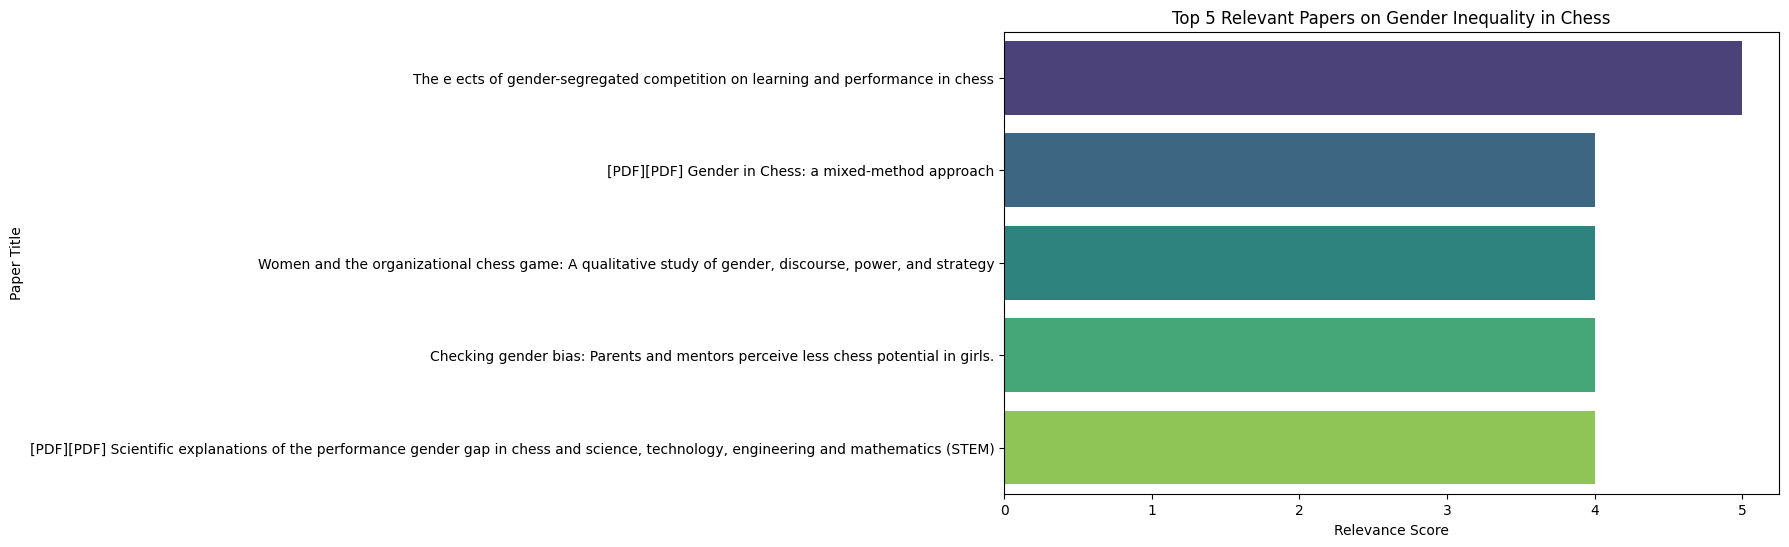

Graph exported as exports/top_papers_graph_2025-09-10_13-52-24.png and exports/top_papers_graph_2025-09-10_13-52-24.svg

Research pipeline completed successfully!
All results have been saved to the 'exports' directory with timestamp: 2025-09-10_13-52-24
You can find detailed logs in the 'logs' directory.


In [10]:
# Visualize Search Results
logging.info("Generating visualizations")

try:
    plt.figure(figsize=(10,6))
    sns.barplot(x='relevance_score', y='title', data=df_top5, palette='viridis')
    plt.title('Top 5 Relevant Papers on Gender Inequality in Chess')
    plt.xlabel('Relevance Score')
    plt.ylabel('Paper Title')
    plt.tight_layout()
    
    # Save with timestamp
    graph_png_path = get_export_path("top_papers_graph", "png")
    graph_svg_path = get_export_path("top_papers_graph", "svg")
    plt.savefig(graph_png_path)
    plt.savefig(graph_svg_path)
    logging.info(f"Saved visualizations to {graph_png_path} and {graph_svg_path}")
    
    # Display the plot
    plt.show()
    
    print(f"Graph exported as {graph_png_path} and {graph_svg_path}")

except Exception as e:
    logging.error(f"Error generating visualizations: {str(e)}")
    print(f"Error generating visualizations: {str(e)}")

# Log completion of the pipeline
logging.info("Pipeline execution completed successfully")
print("\nResearch pipeline completed successfully!")
print(f"All results have been saved to the 'exports' directory with timestamp: {timestamp}")
print("You can find detailed logs in the 'logs' directory.")

# Export Summary

This notebook automatically exports several files for each run:

## Versioned Exports (Timestamped)
- `exports/all_papers_[TIMESTAMP].csv` - All papers found in the search
- `exports/top_papers_[TIMESTAMP].csv` - The top 5 most relevant papers 
- `exports/top_papers_graph_[TIMESTAMP].png` - Bar chart visualization as PNG
- `exports/top_papers_graph_[TIMESTAMP].svg` - Bar chart visualization as SVG
- `exports/README_[TIMESTAMP].md` - Documentation for this specific run

## Latest Version (Always Overwritten)
- `chess_gender_inequality_top5.csv` - The latest top 5 papers (for backward compatibility)

## Logs
- `logs/run_[TIMESTAMP].log` - Detailed execution log with timestamps, queries, and results

Each run creates a new set of files with its own timestamp, so you can compare results over time and keep a history of your research.

In [11]:
# API Integration (Optional)
# Simple API server for programmatic access to research results

from flask import Flask, jsonify, request
import threading
import webbrowser
import time

# Initialize Flask app
app = Flask(__name__)

# Global variable to store the most recent results
current_results = {
    'top_papers': df_top5.to_dict(orient='records') if 'df_top5' in locals() else [],
    'timestamp': timestamp,
    'query': search_query if 'search_query' in locals() else ""
}

@app.route('/', methods=['GET'])
def home():
    """Root endpoint with API documentation"""
    return jsonify({
        'status': 'success',
        'message': 'Chess Gender Inequality Research API',
        'endpoints': [
            {'method': 'GET', 'path': '/api/papers', 'description': 'Get all papers'},
            {'method': 'GET', 'path': '/api/top_papers', 'description': 'Get top papers'},
            {'method': 'POST', 'path': '/api/search', 'description': 'Perform new search'}
        ]
    })

@app.route('/api/papers', methods=['GET'])
def get_papers():
    """API endpoint to get all papers"""
    if 'df_papers' in globals():
        return jsonify({
            'status': 'success',
            'timestamp': timestamp,
            'papers': df_papers.to_dict(orient='records')
        })
    else:
        return jsonify({
            'status': 'error',
            'message': 'No papers available'
        }), 404

@app.route('/api/top_papers', methods=['GET'])
def get_top_papers():
    """API endpoint to get top papers"""
    return jsonify({
        'status': 'success',
        'timestamp': timestamp,
        'papers': current_results['top_papers']
    })

@app.route('/api/search', methods=['POST'])
def search_papers():
    """API endpoint to perform a new search"""
    data = request.json
    if not data or 'query' not in data:
        return jsonify({
            'status': 'error',
            'message': 'Query parameter is required'
        }), 400
    
    # This would normally trigger a new search
    # For demo purposes, we'll just return the current results
    return jsonify({
        'status': 'success',
        'message': f"Search for '{data['query']}' would be performed here",
        'papers': current_results['top_papers']
    })

def start_api_server():
    """Start the API server in a separate thread"""
    # Use 0.0.0.0 to make the server accessible from outside the container
    host = '0.0.0.0'
    port = 5000
    
    # Start the server in a separate thread
    threading.Thread(target=lambda: app.run(host=host, port=port, debug=False, use_reloader=False)).start()
    
    print(f"\nAPI server starting at http://localhost:{port}")
    print("Available endpoints:")
    print(f"  - GET http://localhost:{port}/")
    print(f"  - GET http://localhost:{port}/api/papers")
    print(f"  - GET http://localhost:{port}/api/top_papers")
    print(f"  - POST http://localhost:{port}/api/search (requires JSON body with 'query' field)")
    
    # Wait a moment for the server to start
    time.sleep(2)
    
    # Try to open the browser
    try:
        webbrowser.open(f'http://localhost:{port}/api/top_papers')
        print("\nOpened browser to API endpoint")
    except Exception as e:
        print(f"\nCould not open browser automatically")
        print(f"Access the API manually at http://localhost:{port}/api/top_papers")

# Start the API server
start_api_server()

print("\nEnterprise-ready research pipeline setup complete!")
print("API server has been enabled and started on port 5000.")
print("Note: If using Docker, ensure port 5000 is properly mapped in docker-compose.yml")


API server starting at http://localhost:5000
Available endpoints:
  - GET http://localhost:5000/
  - GET http://localhost:5000/api/papers
  - GET http://localhost:5000/api/top_papers
  - POST http://localhost:5000/api/search (requires JSON body with 'query' field)
 * Serving Flask app '__main__'
 * Debug mode: off

Opened browser to API endpoint

Enterprise-ready research pipeline setup complete!
API server has been enabled and started on port 5000.
Note: If using Docker, ensure port 5000 is properly mapped in docker-compose.yml


# Interactive Dashboard Extension (Optional)

The docker-compose.yml file includes a commented-out dashboard service that can be enabled to provide an interactive web dashboard for research results visualization. This dashboard would:

## Features

1. **Interactive Data Exploration**
   - Visualize paper relevance across different metrics
   - Filter papers by topic, author, or year
   - Compare multiple research runs

2. **Advanced Analytics Dashboard**
   - Sentiment analysis visualization
   - Topic clustering of papers
   - Citation network graphs

3. **Real-time API Integration**
   - Connect directly to the SQLite database
   - Query the research API for live data
   - Export visualizations in multiple formats

## Technical Implementation

The dashboard would run as a separate service in Docker Compose on port 8050 using:
- Plotly Dash for interactive visualization
- Bootstrap components for responsive layout
- SQLAlchemy for database access

## How to Enable

To enable the dashboard:

1. Create a file named `Dockerfile.dashboard` with the following content:
```dockerfile
FROM python:3.9-slim

WORKDIR /app

COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt
RUN pip install --no-cache-dir dash dash-bootstrap-components plotly pandas sqlalchemy

COPY dashboard.py .

EXPOSE 8050

CMD ["python", "dashboard.py"]
```

2. Create a `dashboard.py` file that implements the visualization dashboard
3. Uncomment the dashboard section in `docker-compose.yml`
4. Restart the services with `docker-compose up -d`

The dashboard would then be accessible at http://localhost:8050